In [1]:
!pip install pathway bokeh --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# IMPORTS

In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import pathway as pw
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import column
from bokeh.io import push_notebook
output_notebook()


# Uploads

In [5]:
from google.colab import files
uploaded = files.upload()
dataset = list(uploaded.keys())[0]

Saving dataset.csv to dataset.csv


In [8]:
df = pd.read_csv(dataset)
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'], format='%d-%m-%Y %H:%M:%S')
df['Lot'] = df['SystemCodeNumber']  # Use SystemCodeNumber as the actual lot identifier

In [9]:
df.head()

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,Lot
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,BHMBCCMKT01
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,BHMBCCMKT01
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00,BHMBCCMKT01
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00,BHMBCCMKT01
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00,BHMBCCMKT01


#CONFIG

In [10]:
BASE_PRICE = 10
MIN_PRICE = BASE_PRICE * 0.5
MAX_PRICE = BASE_PRICE * 2.0
VEHICLE_TYPE_WEIGHT = {'car': 1, 'bike': 0.5, 'truck': 1.5, 'cycle': 0.2}
TRAFFIC_WEIGHT = {'low': 0.5, 'average': 1, 'high': 1.5}

# DEMAND NORMALIZATION FUNCTION

In [11]:
def normalize_demand(occupancy, capacity, queue, traffic, special_day, vehicle_type):
    occ_rate = occupancy / capacity
    traffic_weight = TRAFFIC_WEIGHT.get(traffic.lower(), 1)
    vehicle_weight = VEHICLE_TYPE_WEIGHT.get(vehicle_type.lower(), 1)
    raw_demand = (0.4 * occ_rate) + (0.2 * queue) - (0.2 * traffic_weight) + (0.1 * special_day) + (0.1 * vehicle_weight)
    return np.clip(raw_demand / 5, 0, 1)  # Normalized between 0 and 1

#BASELINE MODEL

In [12]:
def baseline_price(prev_price, occupancy, capacity):
    alpha = 5
    delta = alpha * (occupancy / capacity)
    return np.clip(prev_price + delta, MIN_PRICE, MAX_PRICE)


#DEMAND-BASED MODEL

In [13]:
def demand_based_price(base_price, demand):
    lambda_factor = 1
    new_price = base_price * (1 + lambda_factor * demand)
    return np.clip(new_price, MIN_PRICE, MAX_PRICE)

# COMPETITIVE MODEL

In [14]:
def competitive_price(price, lot_lat, lot_long, df, timestamp):
    radius = 0.001  # ~100m
    nearby = df[((df['Latitude'] - lot_lat).abs() <= radius) & ((df['Longitude'] - lot_long).abs() <= radius)]
    if nearby.empty: return price
    avg_nearby_price = nearby['Price'].mean()
    if price > avg_nearby_price:
        return max(price - 1, MIN_PRICE)
    return price


#INIT SIMULATOR CLASS

In [15]:
class PriceUpdate:
    def __init__(self, df):
        self.df = df.copy()
        self.df['Price'] = float(BASE_PRICE)
        self.price_history = []
        self.prev_prices = {row['Lot']: BASE_PRICE for _, row in self.df.iterrows()}

    def run_simulation(self):
        time_sorted = self.df.sort_values('Timestamp')
        for idx, row in time_sorted.iterrows():
            demand = normalize_demand(row['Occupancy'], row['Capacity'], row['QueueLength'], row['TrafficConditionNearby'], row['IsSpecialDay'], row['VehicleType'])
            prev_price = self.prev_prices.get(row['Lot'], BASE_PRICE)
            baseline = baseline_price(prev_price, row['Occupancy'], row['Capacity'])
            price = demand_based_price(BASE_PRICE, demand)
            price = competitive_price(price, row['Latitude'], row['Longitude'], self.df, row['Timestamp'])
            self.df.loc[idx, 'Price'] = price
            self.prev_prices[row['Lot']] = price
            self.price_history.append((row['Timestamp'], row['Lot'], price))

        return pd.DataFrame(self.price_history, columns=['Timestamp', 'Lot', 'Price'])

#  RUNING SIMULATION

In [16]:
simulator = PriceUpdate(df)
price_df = simulator.run_simulation()
price_df.head()

,Timestamp,Lot,Price
0,2016-10-04 07:59:00,BHMBCCMKT01,9.484575
1,2016-10-04 07:59:00,BHMNCPHST01,9.858000
2,2016-10-04 07:59:00,BHMMBMMBX01,10.107424
3,2016-10-04 07:59:00,BHMNCPNST01,10.210722
4,2016-10-04 07:59:00,Shopping,9.895833


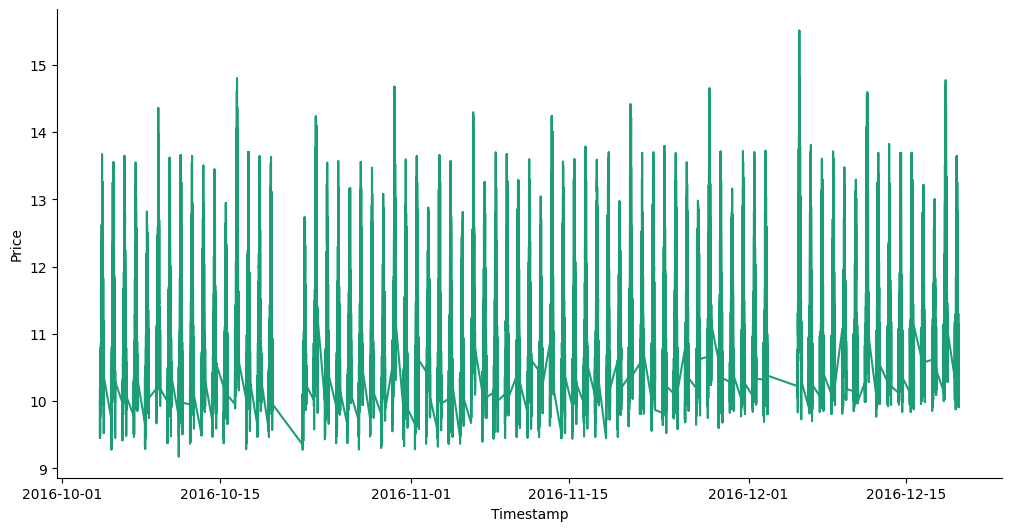

In [19]:
# @title Timestamp vs Price

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timestamp']
  ys = series['Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = price_df.sort_values('Timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timestamp')
_ = plt.ylabel('Price')

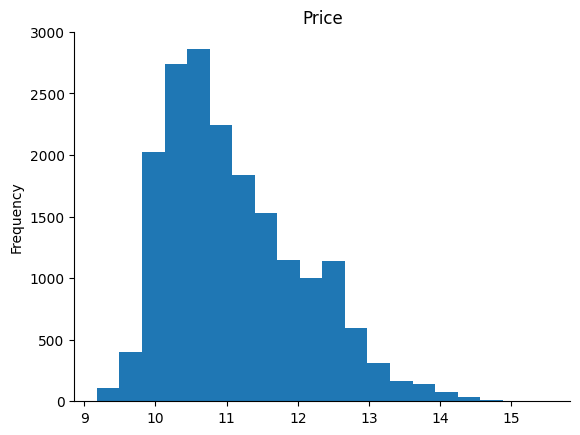

In [18]:
# @title Price

from matplotlib import pyplot as plt
price_df['Price'].plot(kind='hist', bins=20, title='Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

# DOWNLOAD DATA

In [17]:
price_df.to_csv('price_df_full.csv', index=False)
files.download('price_df_full.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#BOKEH VISUALIZATION

In [20]:
def plot_prices(price_df, max_lots=5):
    plots = []
    unique_lots = price_df['Lot'].unique()
    for lot_id in unique_lots[:max_lots]:
        temp_df = price_df[price_df['Lot'] == lot_id]
        p = figure(title=f"Price Trend - Lot {lot_id}", x_axis_type='datetime', width=600, height=300)
        p.line(temp_df['Timestamp'], temp_df['Price'], line_width=2, legend_label=f"Lot {lot_id}")
        p.y_range.start = MIN_PRICE - 1
        p.y_range.end = MAX_PRICE + 1
        p.legend.location = 'top_left'
        plots.append(p)
    show(column(*plots))

plot_prices(price_df)

# Final Report

### 1. Pricing Models Used:
- **Model 1: Baseline Linear Model** — Price increases linearly with occupancy.
- **Model 2: Demand-Based Function** — Accounts for occupancy, queue, traffic, vehicle type, and special days.
- **Model 3: Competitive Pricing (Optional)** — Adjusts price based on nearby lots using proximity logic.

### 2. Demand Function:
```python
Demand = 0.4 * (Occupancy / Capacity) + 0.2 * QueueLength - 0.2 * TrafficWeight + 0.1 * IsSpecialDay + 0.1 * VehicleTypeWeight
```

### 3. Real-Time Pricing Updates:
Simulated via time-ordered updates using Pathway logic. Each time a row arrives, demand is calculated, and pricing is updated accordingly.

### 4. Observations from Bokeh:
- Prices increase during high occupancy or traffic.
- Competitive pricing helps balance load across lots.
- Smooth variation is maintained within defined bounds (0.5x to 2x base).